In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    roc_auc_score,
    average_precision_score
)
from sklearn.calibration import  calibration_curve
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import GPy
import climin
import random


def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

In [6]:
df = pd.read_csv("mock_catalogue.csv")
df = df[(df.zR > 0.05) & (df.zR < 0.85)]
df = df[df["nH"] > 0]
df.head()

,CR,Texp,Bkg,nH,zR,LXsoft,kT,R500carcmin,DetLike,ExtLike
29,0.003204,79.458206,0.002557,5.128280e+20,0.849797,42.8501,1.957054,1.284435,-99.0,-99.0
31,0.004434,75.358246,0.002354,4.980600e+20,0.842538,42.9488,2.879857,1.467060,-99.0,-99.0
32,0.002070,78.015572,0.002558,4.579400e+20,0.834343,42.6379,2.008850,1.198386,-99.0,-99.0
33,0.003002,80.180389,0.002223,4.409510e+20,0.836860,42.8300,1.546029,1.105286,-99.0,-99.0
34,0.019213,76.535736,0.002396,4.612940e+20,0.800603,43.5362,2.736229,1.658467,-99.0,-99.0


In [7]:
features = ["CR", "Texp", "nH", "zR"]
df[features].rename(columns={'zR':'Z'}).describe()

,CR,Texp,nH,Z
count,602084.000000,602084.000000,6.020840e+05,602084.000000
mean,0.031347,211.717067,8.398032e+20,0.429185
std,0.167426,416.252861,1.209410e+21,0.198605
min,0.000225,24.277424,4.735160e+19,0.050006
25%,0.005170,100.445672,2.715750e+20,0.268691
50%,0.010195,139.859901,4.803930e+20,0.412067
75%,0.023268,199.997295,8.554553e+20,0.580620
max,50.458892,27913.451172,2.126690e+22,0.849997


In [8]:
features_to_log = ["CR", "Texp", 'nH']

df_log = df.copy()
df_log[features_to_log] = np.log(df[features_to_log])

In [9]:
L_Ext_cut = 13
L_Det_cut = 0

df_log["detected"] = (df_log["DetLike"] > L_Det_cut) & (df_log["ExtLike"] > L_Ext_cut)
df_log["detected"] = df_log["detected"].astype(int)

print(df_log.detected.value_counts())

0    599261
1      2823
Name: detected, dtype: int64


In [10]:
X = df_log[features].to_numpy()
y = df_log["detected"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=4, stratify=y, shuffle=True
)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
set_random_seed(4)

k = GPy.kern.RBF(
    input_dim=len(features),
    variance=1,
    lengthscale=np.ones(len(features)),
    ARD=True,
    name="rbf"
)

likelihood = GPy.likelihoods.Bernoulli()

m = GPy.core.SVGP(
    X_train,
    y_train.reshape(-1, 1),
    np.random.rand(30, len(features)),
    kernel=k, 
    likelihood=likelihood,
    batchsize=2**16,
)

m

SVGP.,value,constraints,priors
inducing inputs,"(30, 4)",,
rbf.variance,1.0,+ve,
rbf.lengthscale,"(4,)",+ve,
q_u_chol,"(465, 1)",,
q_u_mean,"(30, 1)",,


In [12]:
n_tot = 6_000
pbar = tqdm(total=n_tot)

loss_arr = []

opt = climin.Adadelta(
    m.optimizer_array,
    m.stochastic_grad,
    step_rate=0.1,
    momentum=0,
)

def callback(i):
    loss = -m.log_likelihood()
    loss_arr.append(loss)
    pbar.set_description(f"loss: {loss}")
    pbar.update(1)
    if i['n_iter'] > n_tot:
        return True
    return False

inf = opt.minimize_until(callback)

pbar.close()

loss: 3118.0715720749536: : 6001it [59:25,  1.68it/s]                         


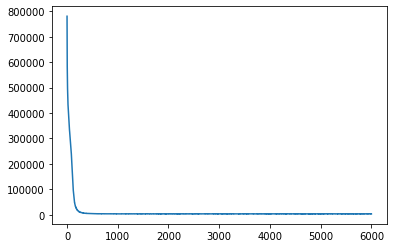

In [13]:
plt.plot(loss_arr[:])
plt.show()

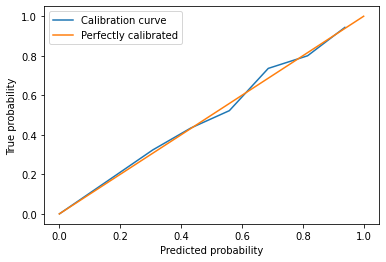

In [16]:
y_pred = m.predict(X_test)

true_pos, pred_pos = calibration_curve(y_test, y_pred[0], n_bins=8)

plt.plot(pred_pos, true_pos, label='Calibration curve')
x = np.linspace(0, 1, 100)
plt.plot(x, x, label='Perfectly calibrated')
plt.legend()
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.show()

In [15]:
print("Train AP", average_precision_score(y_train, m.predict(X_train)[0]))
print("Test AP", average_precision_score(y_test, m.predict(X_test)[0]))

Train AP 0.7133112228420829
Test AP 0.6907097507589239


In [73]:
y_pred = (m.predict(X_test)[0] > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199754
           1       0.73      0.50      0.59       941

    accuracy                           1.00    200695
   macro avg       0.86      0.75      0.80    200695
weighted avg       1.00      1.00      1.00    200695

ROC AUC: 0.7498276360263187


In [74]:
print(m)
print(m.kern.lengthscale)


Name : SVGP
Objective : 3118.0715720749536
Number of Parameters : 620
Number of Optimization Parameters : 620
Updates : True
Parameters:
  SVGP.            |               value  |  constraints  |  priors
  inducing_inputs  |             (30, 4)  |               |        
  rbf.variance     |  6.1489315814562975  |      +ve      |        
  rbf.lengthscale  |                (4,)  |      +ve      |        
  q_u_chol         |            (465, 1)  |               |        
  q_u_mean         |             (30, 1)  |               |        
  index  |  SVGP.rbf.lengthscale  |  constraints  |  priors
  [0]    |            0.37967254  |      +ve      |        
  [1]    |            0.65678953  |      +ve      |        
  [2]    |            1.00036616  |      +ve      |        
  [3]    |            1.38038324  |      +ve      |        


In [75]:
model_parameters = m.param_array
np.save('model_parameters.npy', model_parameters)

scaler_min = scaler.min_
scaler_scale = scaler.scale_
scaler_parameters = np.array([scaler_min, scaler_scale])

np.save('scaler_parameters.npy', scaler_parameters)